# Homework1. Blackjack

Данная работа выполнена в качестве домашнего задания по курсу "Продвинутое глубокое обучение и обучение с подкреплением" в академии больших данных MADE.

В данной работе обучение с подкреплением используется для обучения игре в блекджек. 

Первоначально начнём с самой базовой версии игры, которая реализована в OpenAI Gym:

 - численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
 - туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (usable ace), и за 1 очко, если превосходит;
 - игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
 - игрок может совершать одно из двух действий:
 
    ○	hit  — взять ещё одну карту;
    
    ○	stand — не брать больше карт;
    
 - если сумма очков у игрока на руках больше 21, он проигрывает (bust);
 - если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
 - после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
 - в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

### Импорт библиотек и загрузка среды

In [1]:
import gym
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from functools import partial
from tqdm import tqdm

import random
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

## 1. Часть первая, с блекджеком и стратегиями

### 1.1. Простейшая стратегия

Первоначально рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. 

In [2]:
def sample_policy(observation):
    score, _, _ = observation
    return 0 if score >= 19 else 1

Используя методы Монте-Карло, оценим выигрыш от данной стратегии.

Определим метод для генерации эпизодов обучения, используя заданную политику. Будем хранить информацию о состоянии, действиях и полученных вознаграждениях.

In [3]:
def generate_episode(policy, env):
    states, actions, rewards = [], [], []
    final_reward = 0
    observation, _ = env.reset()  
    while True:
        states.append(observation)

        action = policy(observation)
        actions.append(action)
        
        observation, reward, done, _, info = env.step(action)
        rewards.append(reward)

        if done:
            final_reward = reward
            break
    return states, actions, rewards, final_reward

Оценим средний выигрыш данной стратегии на 100000 раздач.

In [4]:
env = gym.make('Blackjack-v1')
N = 100000
sum_rewards = 0
for _ in range(N):
    _, _, _, final_reward = generate_episode(sample_policy, env)
    sum_rewards += final_reward
print('Средний выигрыш данной стратегии = {} ставки'.format(round(sum_rewards / N, 2)))

Средний выигрыш данной стратегии = -0.2 ставки


Т.о. данная стратегия проигрышная для игрока. Средняя сумма проигрыша - 20% от ставки.

### 1.2. Обучение стратегии методом Monte Carlo Estimation.

Используя метод Monte Carlo Estimation, оценим Q функцию заданной стратегии: для каждой пары состояние-действие оценим среднее ожидаемое вознаграждение. Учитывая скорость игры блекджек и важность именно итогового выигрыша/проигрыша, дисконтирование использовать не будем.

Построим итерационный алгоритм приближения оптимальной стратегии:
 - в качестве инициализации политики будем использовать sample_policy,
 - для каждой пары состояние/действие посчитаем среднее значение награды при следовании данной стратегии, в результате получим словарь value_table, в котором для каждой пары состояние-действие хранится ожидаемая награда, 
 - обновим политику следующим образом: для каждого состояния проверяем, при каком действии (hit или stand) ожидаемая награда выше и возвращаем действие с максимальной наградой,
 - переходим к следующему шагу с обновленной политикой.

In [5]:
class MC_estimation:
    def __init__(self, env, policy):
        self.env = env
        self.policy = policy
        self.value_table = defaultdict(float)
        self.mean_rewards = []
        
    def optimal_policy(self, observation):
        if self.value_table[(observation, 0)] > self.value_table[(observation, 1)]:
            return 0
        else:
            return 1
    
    def generate_episode(self, policy):
        states, actions, rewards = [], [], []
        final_reward = 0
        observation, _ = self.env.reset()  
        while True:
            states.append(observation)

            action = policy(observation)
            actions.append(action)

            observation, reward, done, _, info = self.env.step(action)
            rewards.append(reward)

            if done:
                final_reward = reward
                break
        return states, actions, rewards, final_reward
    
  
    def q_estimation(self, policy, n_episodes):
        new_value_table = defaultdict(float)
        N = defaultdict(int)
        
        sum_reward = 0

        for _ in range(n_episodes):
            states, actions , rewards, final_reward = self.generate_episode(policy)
            sum_reward += final_reward
            returns = 0

            for t in range(len(states) - 1, -1, -1):
                R = rewards[t]
                S = states[t]
                A = actions[t]
                returns += R

                if S not in states[:t]:
                    N[(S, A)] += 1
                    new_value_table[(S, A)] += (returns - new_value_table[(S, A)]) / N[(S, A)]
        return new_value_table, sum_reward / n_episodes

    def fit(self, n_iter, n_episodes):
        self.value_table, mean_reward = self.q_estimation(self.policy, n_episodes)
        self.mean_rewards.append(mean_reward)
        
        for _ in tqdm(range(n_iter)):
            self.value_table, mean_reward = self.q_estimation(self.optimal_policy, n_episodes)
            self.mean_rewards.append(mean_reward)

    
    def learning_view(self):
        plt.figure(figsize=(15,8))
        ax = sns.scatterplot(range(len(self.mean_rewards)),self.mean_rewards)
        ax.set_ylim(-0.2,-0.1),
        ax.set(
            xlabel="#episodes",
            ylabel="Средний выгрыш",
            title="Динамика среднего выгрыша в процессе обучения, усредненного по 100 000 раздач"
        )
        plt.show()
    

    def optimal_policy_mean_reward(self, N):
        sum_rewards = 0
        for _ in range(N):
            _, _, _, final_reward = self.generate_episode(self.optimal_policy)
            sum_rewards += final_reward
        print('Средний выигрыш данной стратегии = {} ставки'.format(round(sum_rewards / N, 2)))

Обучим стратегию таким образом, проанализируем средний выигрыш в процессе обучения(после каждого обновления Q-функции и стратегии) и оценим средний выигрыш от полученной итоговой стратегии.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [14:19<00:00,  8.59s/it]

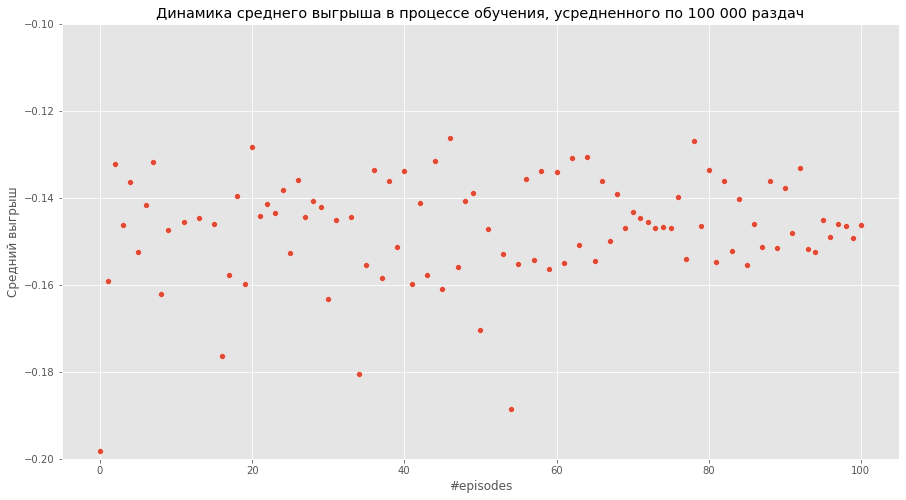

Средний выигрыш данной стратегии = -0.15 ставки


In [6]:
env = gym.make('Blackjack-v1')

policy = MC_estimation(env, sample_policy)
policy.fit(n_iter = 100, n_episodes = 100_000)
print()
policy.learning_view()
policy.optimal_policy_mean_reward(100_000)

Видим, что проигрыш новой обученной стратегии немного уменьшился.

### 1.3. Обучение методом on-policy Monte Carlo control


Попробуем теперь применить методы on-policy Monte Carlo control. Будем обновлять политику каждый раз при обновлении значений Q-функции. Кроме того, добавим случайность в выбор шагов: с вероятноятью $1-\epsilon$ будем действовать по текущей политике, а с вероятностью $\epsilon$ совершать случайное действие.

Сначала проанализируем обучение стратегии без случайности (при $\epsilon = 0$), а потом будем увеличивать $\epsilon$ и проанализируем качество получающейся модели.

In [7]:
def sample_policy(observation):
    score, _, _ = observation
    return 0 if score >= 19 else 1

In [8]:
class MC_control_on_policy:
    def __init__(self, env, policy, eps=0.1):
        self.env = env
        self.policy = policy
        self.eps = eps
        self.value_table = defaultdict(float)
        self.mean_rewards = []
    
    def generate_episode(self, policy):
        states, actions, rewards = [], [], []
        final_reward = 0
        observation, _ = self.env.reset()  
        while True:
            states.append(observation)

            action = policy(observation)
            actions.append(action)

            observation, reward, done, _, info = self.env.step(action)
            rewards.append(reward)

            if done:
                final_reward = reward
                break
        return states, actions, rewards, final_reward
    
    def policy_soft(self, observation):
        p = random.random()

        if p < self.eps:
            return random.choice([0 , 1])
        
        if self.value_table[(observation, 0)] > self.value_table[(observation, 1)]:
            return 0
        else:
            return 1
    
    def fit(self, n_episodes):
        N = defaultdict(int)
        
        cur_sum_reward = 0

        for i in tqdm(range(n_episodes)):
            states, actions , rewards, final_reward = self.generate_episode(self.policy)
            returns = 0

            if i % 100000 == 0:
                self.mean_rewards.append(cur_sum_reward / 100000)
                cur_sum_reward = 0

            cur_sum_reward += final_reward

            for t in range(len(states) - 1, -1, -1):
                R = rewards[t]
                S = states[t]
                A = actions[t]
                returns += R


                if S not in states[:t]:
                    N[(S, A)] += 1
                    self.value_table[(S, A)] += (returns - self.value_table[(S, A)]) / N[(S, A)]

                    self.policy = self.policy_soft
    
    def learning_view(self):
        plt.figure(figsize=(15,8))
        ax = sns.scatterplot(range(len(self.mean_rewards)),self.mean_rewards)
        ax.set_ylim(-0.2, 0)
        ax.set(
            xlabel="#episodes",
            ylabel="Средний выгрыш",
            title="Динамика среднего выгрыша в процессе обучения, усредненного по 100 000 раздач"
        )
        plt.show()
    
    def optimal_policy(self, observation):
        if self.value_table[(observation, 0)] > self.value_table[(observation, 1)]:
            return 0
        else:
            return 1
    
    
    def optimal_policy_mean_reward(self, N):
        sum_rewards = 0
        for _ in range(N):
            _, _, _, final_reward = self.generate_episode(self.optimal_policy)
            sum_rewards += final_reward
        print('Средний выигрыш данной стратегии = {} ставки'.format(round(sum_rewards / N, 2)))

  0%|                                                                       | 1116/10000000 [00:00<14:59, 11115.25it/s]

EPS = 0


100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [16:28<00:00, 10117.52it/s]


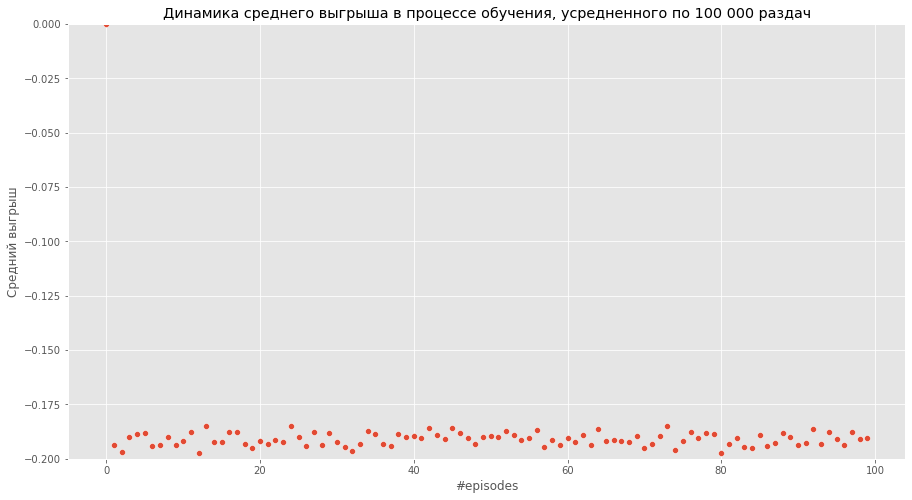

  0%|                                                                       | 2034/10000000 [00:00<16:11, 10296.23it/s]

Средний выигрыш данной стратегии = -0.19 ставки

EPS = 0.05


100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [15:57<00:00, 10438.58it/s]


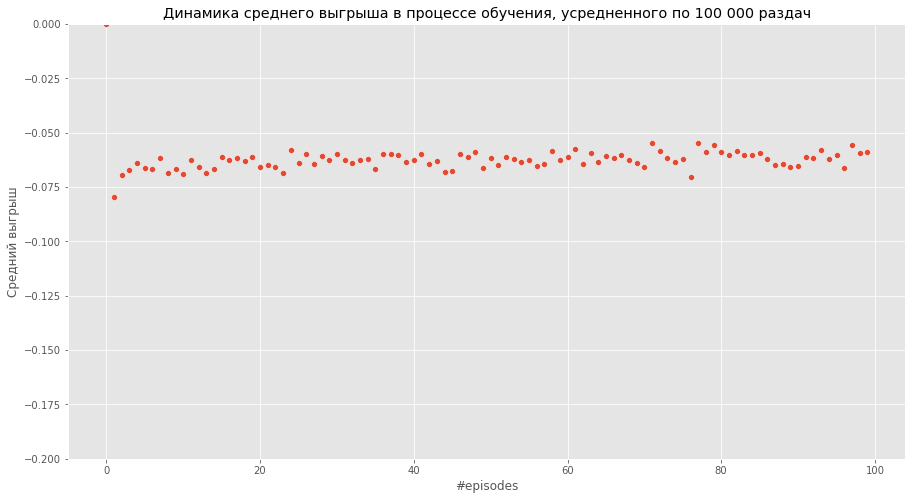

  0%|                                                                       | 2045/10000000 [00:00<16:20, 10196.24it/s]

Средний выигрыш данной стратегии = -0.05 ставки

EPS = 0.1


100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [15:36<00:00, 10683.31it/s]


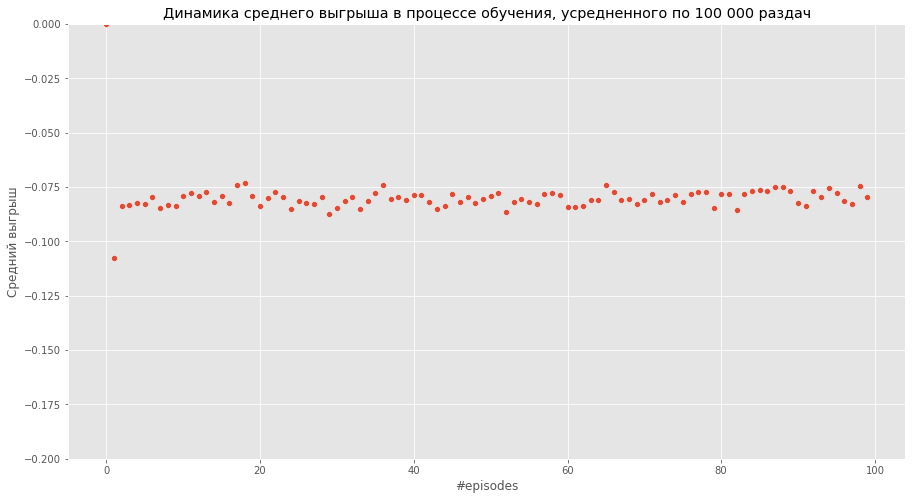

  0%|                                                                       | 1137/10000000 [00:00<14:48, 11257.44it/s]

Средний выигрыш данной стратегии = -0.04 ставки

EPS = 0.3


100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [15:25<00:00, 10808.93it/s]

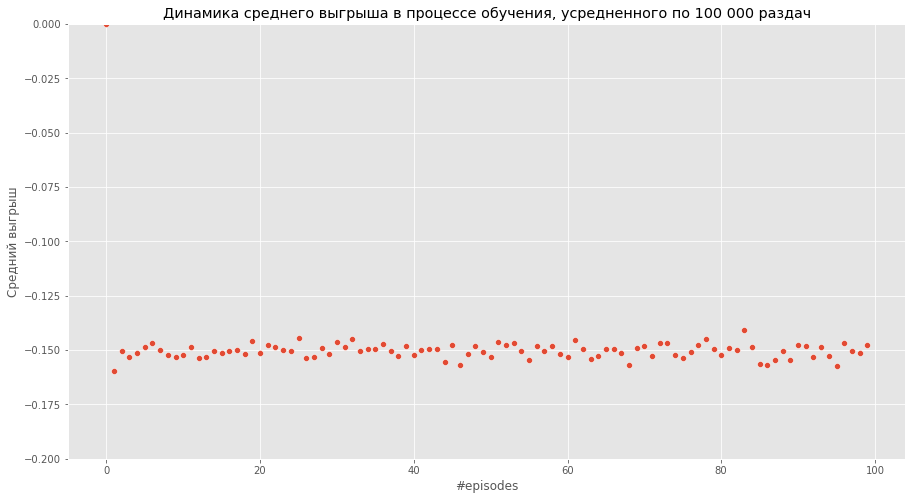

Средний выигрыш данной стратегии = -0.05 ставки



In [9]:
env = gym.make('Blackjack-v1')
policy = sample_policy

for eps in [0, 0.05, 0.1, 0.3]:
    print('EPS = {}'. format(eps))
    soft_policy = MC_control_on_policy(env, policy, eps)
    soft_policy.fit(10_000_000)
    print()
    soft_policy.learning_view()
    soft_policy.optimal_policy_mean_reward(100_000)
    print()

Получается, что без добавления случайности средний проигрыш обученной стратегии примерно равен 19% от ставки. При добавлении случайности средний проигрыш заметно уменьшается - до 4-5% от ставки. Причем, как показывают эксперименты, значение параметра $\epsilon$ не сильно влияет на проигрыш итоговой политики (итоговая поолитика на инференсе - уже без случайности, выбирается лучший ход по обученной стратегии). Т.е. при добавлении случайности с любой вероятностью при достаточно большом количестве экспериментов алгоритм сходится примерно к одной и той же стратегии.

### 1.4. Q-learning

Теперь попробуем обучить политику методом Q-learning. При каждом обновлении ожидаемого выигрыша при данном состоянии будем учитывать максимальный ожидаемый выигрыш следующего состояния.

In [10]:
class Q_learning:
    def __init__(self, env, eps, learning_rate, gamma):
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.eps = eps
        self.value_table = defaultdict(float)
        self.mean_rewards = []

    def generate_episode(self, policy):
        states, actions, rewards = [], [], []
        final_reward = 0
        observation, _ = self.env.reset()  
        while True:
            states.append(observation)

            action = policy(observation)
            actions.append(action)

            observation, reward, done, _, info = self.env.step(action)
            rewards.append(reward)

            if done:
                final_reward = reward
                break
        return states, actions, rewards, final_reward
    
    def policy_soft(self, observation):
        p = random.random()

        if p < self.eps:
            return random.choice([0 , 1])
        
        if self.value_table[(observation, 0)] > self.value_table[(observation, 1)]:
            return 0
        else:
            return 1
    
    def fit(self, n_episodes):
        
        cur_sum_rewards = 0
        for i in tqdm(range(n_episodes)):
            state, _ = self.env.reset()
            done = False
            
            while not done:
                action = self.policy_soft(state)
                next_state, reward, done, _, info = self.env.step(action)
                td_target = reward + self.gamma * max(self.value_table[(next_state, 0)], self.value_table[(next_state, 1)])
                td_error = td_target - self.value_table[(state, action)]
                self.value_table[(state, action)] += self.learning_rate * td_error
                state = next_state
                
                if done:
                    cur_sum_rewards += reward
            
            if i % 10000 == 0:
                self.mean_rewards.append(cur_sum_rewards / 10000)
                cur_sum_rewards = 0
                    
    
    def learning_view(self):
        plt.figure(figsize=(15,8))
        ax = sns.scatterplot(range(len(self.mean_rewards)),self.mean_rewards)
        ax.set_ylim(-0.3, 0)
        ax.set(
            xlabel="#episodes",
            ylabel="Средний выгрыш",
            title="Динамика среднего выгрыша в процессе обучения, усредненного по 10000 раздач"
        )
        plt.show()
    
    def optimal_policy(self, observation):
        if self.value_table[(observation, 0)] > self.value_table[(observation, 1)]:
            return 0
        else:
            return 1
    
    
    def optimal_policy_mean_reward(self, N):
        sum_rewards = 0
        for _ in range(N):
            _, _, _, final_reward = self.generate_episode(self.optimal_policy)
            sum_rewards += final_reward
        print('Средний выигрыш данной стратегии = {} ставки'.format(round(sum_rewards / N, 2)))

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:09<00:00, 10709.51it/s]


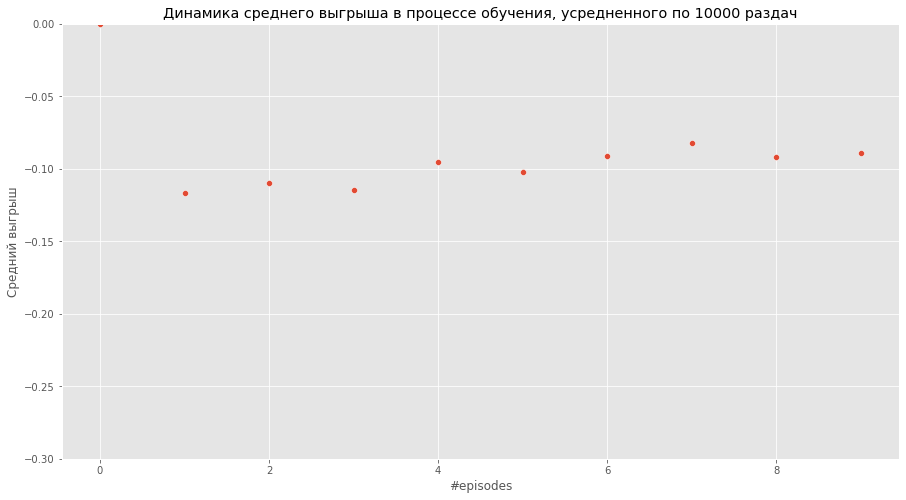

Средний выигрыш данной стратегии = -0.07 ставки


In [23]:
env = gym.make('Blackjack-v1')
gamma = 1
eps = 0.05
learning_rate = 0.00001

q_policy = Q_learning(env, eps, learning_rate, gamma)
q_policy.fit(100_000)
q_policy.learning_view()
q_policy.optimal_policy_mean_reward(100_000)

При проведении экспериментов с обучением стратегии по алгоритму Q-learning выявлена особенность: при увеличении количества экспериментов (n_estimation) качество итоговой стратегии существенно снижается: если при n_estimation = 100_000 средний проигрыш составляет примерно 6-7% от ставки, то при увеличении n_estimation до 10_000_000 проигрыш получается уже около 18-20%. Также замечено, что качество обучения значительно ухудшается при увеличении learning rate.

Таким образом, в рассматриваемой задаче наилучший результат обучения политики получен при методе on-policy Monte Carlo control.
Вероятно, это является особенностью задачи. В дальнейшем в этой работе для обучения политики в других вариантах октужения будем использовать именно on-policy Monte Carlo control.

## 2. Часть вторая, удвоенная

Во второй части работы реализуйем новый вариант блекджека на основе окружения, в котором разрешено удвоение ставки.
Добавим возможность совершения еще одного действия **double** — удвоить ставку. При этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

Реализуем окружение с дополнительным действием: 2 - double:

In [12]:
from gym import spaces
from gym.envs.toy_text.blackjack import BlackjackEnv

class DoubleBlackjack(BlackjackEnv):
    def __init__(self, *args, **kwargs):
        super(DoubleBlackjack, self).__init__(*args, **kwargs)
        
        self.action_space = spaces.Discrete(3)
        self.reset()
        
    def step(self, action):
        assert self.action_space.contains(action)
        reward = max(action, 1)
        res = list(super(DoubleBlackjack, self).step(min(action, 1)))
        if action == 2 and not res[2]:
            res = list(super(DoubleBlackjack, self).step(0))
        res[1] *= reward
        return res

По аналогии с первой частью обучим оптимальную стратегию методом on-policy MC control

In [13]:
def sample_policy(observation):
    score, _, _ = observation
    return 0 if score >= 19 else 1

In [14]:
class MC_control_on_policy_double:
    def __init__(self, env, policy, eps=0.1):
        self.env = env
        self.policy = policy
        self.eps = eps
        self.value_table = defaultdict(float)
        self.mean_rewards = []
    
    def generate_episode(self, policy):
        states, actions, rewards = [], [], []
        final_reward = 0
        observation, _ = self.env.reset()  
        while True:
            states.append(observation)

            action = policy(observation)
            actions.append(action)

            observation, reward, done, _, info = self.env.step(action)
            rewards.append(reward)

            if done:
                final_reward = reward
                break
        return states, actions, rewards, final_reward
    
    def policy_soft(self, observation):
        p = random.random()

        if p < self.eps:
            return random.choice([0, 1, 2])
        
        if self.value_table[(observation, 0)] >= self.value_table[(observation, 1)] and self.value_table[(observation, 0)] >= self.value_table[(observation, 2)]:
            return 0
        
        elif self.value_table[(observation, 1)] >= self.value_table[(observation, 0)] and self.value_table[(observation, 1)] >= self.value_table[(observation, 2)]:
            return 1
        
        else:
            return 2
    
    def fit(self, n_episodes):
        N = defaultdict(int)
        
        cur_sum_reward = 0

        for i in tqdm(range(n_episodes)):
            states, actions , rewards, final_reward = self.generate_episode(self.policy)
            returns = 0

            if i % 100000 == 0:
                self.mean_rewards.append(cur_sum_reward / 100000)
                cur_sum_reward = 0

            cur_sum_reward += final_reward

            for t in range(len(states) - 1, -1, -1):
                R = rewards[t]
                S = states[t]
                A = actions[t]
                returns += R


                if S not in states[:t]:
                    N[(S, A)] += 1
                    self.value_table[(S, A)] += (returns - self.value_table[(S, A)]) / N[(S, A)]

                    self.policy = self.policy_soft
    
    def learning_view(self):
        plt.figure(figsize=(15,8))
        ax = sns.scatterplot(range(len(self.mean_rewards)),self.mean_rewards)
        ax.set_ylim(-0.2, 0)
        ax.set(
            xlabel="#episodes",
            ylabel="Средний выгрыш",
            title="Динамика среднего выгрыша в процессе обучения, усредненного по 100 000 раздач"
        )
        plt.show()
    
    def optimal_policy(self, observation):
        if self.value_table[(observation, 0)] >= self.value_table[(observation, 1)] and self.value_table[(observation, 0)] >= self.value_table[(observation, 2)]:
            return 0
        
        elif self.value_table[(observation, 1)] >= self.value_table[(observation, 0)] and self.value_table[(observation, 1)] >= self.value_table[(observation, 2)]:
            return 1
        
        else:
            return 2
    
    
    def optimal_policy_mean_reward(self, N):
        sum_rewards = 0
        for _ in range(N):
            _, _, _, final_reward = self.generate_episode(self.optimal_policy)
            sum_rewards += final_reward
        print('Средний выигрыш данной стратегии = {} ставки'.format(round(sum_rewards / N, 2)))

  0%|                                                                       | 1172/10000000 [00:00<14:18, 11640.50it/s]

EPS = 0


100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [14:53<00:00, 11191.43it/s]

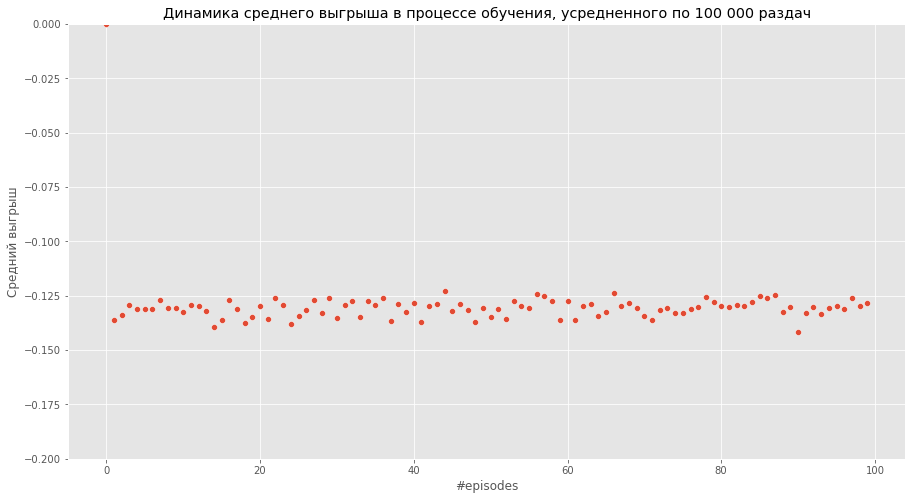

  0%|                                                                       | 2349/10000000 [00:00<14:13, 11714.45it/s]

Средний выигрыш данной стратегии = -0.13 ставки

EPS = 0.05


100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [15:35<00:00, 10686.92it/s]


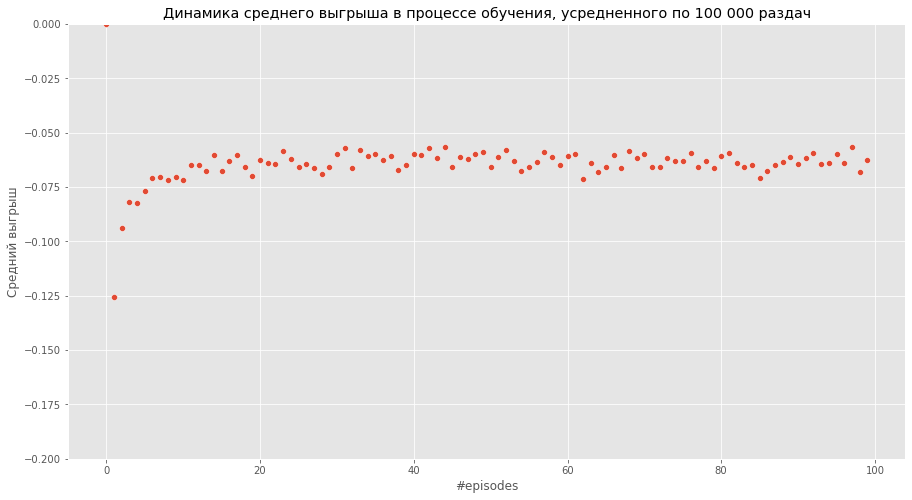

  0%|                                                                       | 1171/10000000 [00:00<14:13, 11709.23it/s]

Средний выигрыш данной стратегии = -0.03 ставки

EPS = 0.1


100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [15:32<00:00, 10724.14it/s]


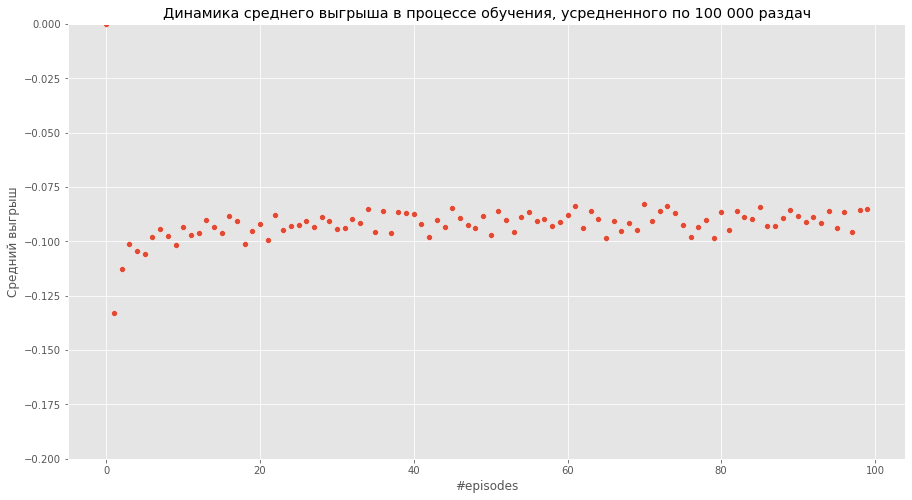

  0%|                                                                       | 2324/10000000 [00:00<14:27, 11529.14it/s]

Средний выигрыш данной стратегии = -0.03 ставки

EPS = 0.3


100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [15:23<00:00, 10824.58it/s]


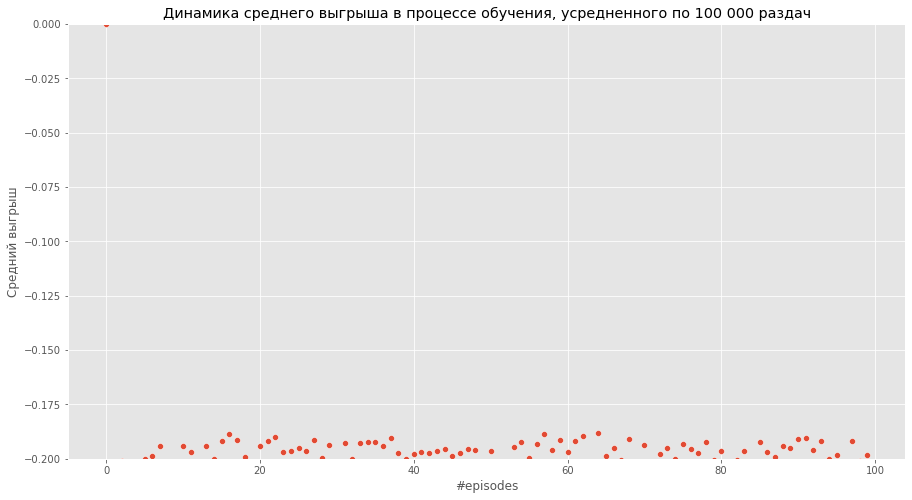

Средний выигрыш данной стратегии = -0.05 ставки



In [15]:
env = DoubleBlackjack()
policy = sample_policy

for eps in [0, 0.05, 0.1, 0.3]:
    print('EPS = {}'. format(eps))
    soft_policy = MC_control_on_policy_double(env, policy, eps)
    soft_policy.fit(10_000_000)
    print()
    soft_policy.learning_view()
    soft_policy.optimal_policy_mean_reward(100_000)
    print()

Видим, что результаты работы обученной модели с дополнительным действием получились чуть-чуть лучше, чем без него. При $\epsilon = 0.1$ средний проигрыш составил 3% от ставки, в случае с двумя действиями он был 4% от ставки.

## Часть 3. В главной роли — Дастин Хоффман

Реализуем вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. 
После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается. Для определённости будем считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.
Т.о. игрок может считать вышедшие карты, тем самым повышая свои шансы на выигрыш.

Будем считать карты в колоде по системе половинки:

card points

2 +0.5

3, 4 +1

5 +1.5

6 +1

7 +0.5

8 0

9 −0,5

10, В, Д, К, Т −1

In [16]:
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4

cost = defaultdict(float)

cost.update({
    2: +0.5,
    3: +1,
    4: +1,
    5: +1.5,
    6: +1,
    7: +0.5,
    9: -0.5,
    10: -1,
})

In [17]:
from gym.envs.toy_text.blackjack import sum_hand
from gym.envs.toy_text.blackjack import (
    cmp, is_bust, is_natural, score, sum_hand
)

class DoubleCountingBlackjackEnv(DoubleBlackjack):

    DEALER_SUM_THRESHOLD = 17

    def __init__(self, *args, **kwargs):
        self.counter = 0
        self.deck = deck.copy()
        
        super(
            DoubleCountingBlackjackEnv, 
            self
        ).__init__(*args, **kwargs)

    def reset(self):
        if len(self.deck) <= 15:

            self.counter = 0
            self.deck = deck.copy()
        
        self.dealer = self.draw_hand()
        
        self.player = self.draw_hand()
        
        return self._get_obs()

    def step(self, action):
        assert self.action_space.contains(action)

        if action:  
            self.player.append(self.draw_card())

            if not is_bust(self.player):
                done = False
                reward = 0.
            else:
                done = True
                reward = -1.
              
        else:  
            done = True

            while sum_hand(self.dealer) < self.DEALER_SUM_THRESHOLD:
                self.dealer.append(self.draw_card())

            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5

        return self._get_obs(), reward, done, {}
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]

    def draw_card(self):
        card = self.np_random.choice(self.deck)
        self.deck.remove(card)
        self.counter += cost[card]
        return int(card)

    def _get_obs(self):
        return (
            *super(DoubleCountingBlackjackEnv, self)._get_obs(), 
            self.counter
        )

In [18]:
def sample_policy(observation):
    score, _, _, _ = observation
    return 0 if score >= 19 else 1

In [19]:
class MC_control_on_policy_double_counting:
    def __init__(self, env, policy, eps=0.1):
        self.env = env
        self.policy = policy
        self.eps = eps
        self.value_table = defaultdict(float)
        self.mean_rewards = []
    
    def generate_episode(self, policy):
        states, actions, rewards = [], [], []
        final_reward = 0
        observation = self.env.reset()  
        while True:
            states.append(observation)

            action = policy(observation)
            actions.append(action)

            observation, reward, done,info = self.env.step(action)
            rewards.append(reward)

            if done:
                final_reward = reward
                break
        return states, actions, rewards, final_reward
    
    def policy_soft(self, observation):
        p = random.random()

        if p < self.eps:
            return random.choice([0, 1, 2])
        
        if self.value_table[(observation, 0)] > self.value_table[(observation, 1)] and self.value_table[(observation, 0)] > self.value_table[(observation, 2)]:
            return 0
        
        elif self.value_table[(observation, 1)] > self.value_table[(observation, 0)] and self.value_table[(observation, 1)] > self.value_table[(observation, 2)]:
            return 1
        
        else:
            return 2
    
    def fit(self, n_episodes):
        N = defaultdict(int)
        
        cur_sum_reward = 0

        for i in tqdm(range(n_episodes)):
            states, actions , rewards, final_reward = self.generate_episode(self.policy)
            returns = 0

            if i % 100000 == 0:
                self.mean_rewards.append(cur_sum_reward / 100000)
                cur_sum_reward = 0

            cur_sum_reward += final_reward

            for t in range(len(states) - 1, -1, -1):
                R = rewards[t]
                S = states[t]
                A = actions[t]
                returns += R


                if S not in states[:t]:
                    N[(S, A)] += 1
                    self.value_table[(S, A)] += (returns - self.value_table[(S, A)]) / N[(S, A)]

                    self.policy = self.policy_soft
    
    def learning_view(self):
        plt.figure(figsize=(15,8))
        ax = sns.scatterplot(range(len(self.mean_rewards)),self.mean_rewards)
        ax.set_ylim(-0.2, 0)
        ax.set(
            xlabel="#episodes",
            ylabel="Средний выгрыш",
            title="Динамика среднего выгрыша в процессе обучения, усредненного по 100 000 раздач"
        )
        plt.show()
    
    def optimal_policy(self, observation):
        if self.value_table[(observation, 0)] >= self.value_table[(observation, 1)] and self.value_table[(observation, 0)] >= self.value_table[(observation, 2)]:
            return 0
        
        elif self.value_table[(observation, 1)] >= self.value_table[(observation, 0)] and self.value_table[(observation, 1)] >= self.value_table[(observation, 2)]:
            return 1
        
        else:
            return 2
    
    
    def optimal_policy_mean_reward(self, N):
        sum_rewards = 0
        for _ in range(N):
            _, _, _, final_reward = self.generate_episode(self.optimal_policy)
            sum_rewards += final_reward
        print('Средний выигрыш данной стратегии = {} ставки'.format(round(sum_rewards / N, 2)))

Так как в предыдущих частях лучшие результаты обучения политики получились при $\epsilon = 0.1$, будем использовать это же значение и в этот раз.

100%|███████████████████████████████████████████████████████████████████| 10000000/10000000 [15:19<00:00, 10873.64it/s]


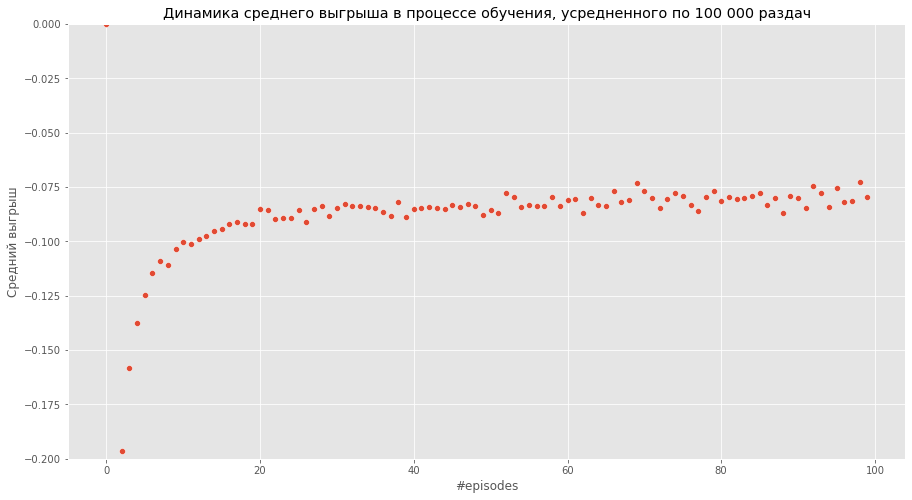

Средний выигрыш данной стратегии = -0.04 ставки


In [24]:
env = DoubleCountingBlackjackEnv()
policy = sample_policy

eps = 0.1
soft_policy = MC_control_on_policy_double_counting(env, policy, eps)
soft_policy.fit(10_000_000)
soft_policy.learning_view()
soft_policy.optimal_policy_mean_reward(100_000)


Средний проигрыш при этой стратегии составил примерно 4% от ставки (примерно на уровне того, что было в части 2).

Вероятно, небольшое ухудшение результата связано с увеличением общего числа состояний (так как в каждом состоянии учитывается еще и статистика по выбывшим картам). 
Без введения в окружение дополнительных действий по увеличению/снижению ставки в зависимости от выбывших карт сам по себе подсчет карт не улучшает стратегию.

**Выводы:**
1. В данной работе проведены эксперименты по обучению игре blackjack с различными вариантами окружения и различными алгоритмами обучения.
2. Лучшие результаты получены при варианте игры с возможностью удвоения ставки, но без подсчета карт. При обучении политике по стратегии "on-policy Monte Carlo control" средний проигрыш оптимальной стратегии составил примерно 3% от ставки.
3. Вариант игры с подсчетом карт, но без введения дополнительных действий по увеличению/снижению ставки в зависимости от выбывших карт не дал преимущества по сравнению с вариантом без подсчета.
4. Как и ожидалось, обыграть казино, к сожалению, нашему агенту не удалось.